## Interference Injection 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_interference_schedule(filename):
    """
    Plots active replicas per pod type on each node using 
    proper cycle-based tracking of create/delete intervals.
    X-axis is in minutes.
    """
    df = pd.read_csv(filename)
    df['replicas'] = pd.to_numeric(df['replicas'], errors='coerce').fillna(0).astype(int)

    # Build a list of cycles per deployment
    cycles = []
    for dep in df['deployment_name'].unique():
        creates = df[(df['deployment_name'] == dep) & (df['action'] == 'create')].sort_values('timestamp_sec')
        deletes = df[(df['deployment_name'] == dep) & (df['action'] == 'delete')].sort_values('timestamp_sec')

        for i in range(min(len(creates), len(deletes))):
            create_time = creates.iloc[i]['timestamp_sec']
            delete_time = deletes.iloc[i]['timestamp_sec']
            replicas = creates.iloc[i]['replicas']
            dtype = creates.iloc[i]['type']
            node = "node1" if "node1" in dep else "node2"
            cycles.append((create_time, delete_time, replicas, dtype, node))

    # Build timeline and initialize counters
    timeline = np.arange(0, df['timestamp_sec'].max() + 10, 10)
    timeline_min = timeline / 60  # convert to minutes
    node1 = {'ibench-cpu': [], 'ibench-l3': [], 'ibench-membw': []}
    node2 = {'ibench-cpu': [], 'ibench-l3': [], 'ibench-membw': []}

    for t in timeline:
        active1 = {'ibench-cpu': 0, 'ibench-l3': 0, 'ibench-membw': 0}
        active2 = {'ibench-cpu': 0, 'ibench-l3': 0, 'ibench-membw': 0}

        for start, end, reps, dtype, node in cycles:
            if start <= t < end:
                if node == "node1":
                    active1[dtype] += reps
                else:
                    active2[dtype] += reps

        for k in active1:
            node1[k].append(active1[k])
            node2[k].append(active2[k])

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    axs[0].stackplot(timeline_min,
                     node1['ibench-cpu'],
                     node1['ibench-l3'],
                     node1['ibench-membw'],
                     labels=['cpu', 'l3', 'membw'],
                     alpha=0.7)
    axs[0].set_title("Node 1 Interference Over Time")
    axs[0].set_ylabel("Active Replicas")
    axs[0].legend(loc='upper left')

    axs[1].stackplot(timeline_min,
                     node2['ibench-cpu'],
                     node2['ibench-l3'],
                     node2['ibench-membw'],
                     labels=['cpu', 'l3', 'membw'],
                     alpha=0.7)
    axs[1].set_title("Node 2 Interference Over Time")
    axs[1].set_xlabel("Time (minutes)")
    axs[1].set_ylabel("Active Replicas")
    axs[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

### Ramp Up Schedule

In [22]:
# === Configurable Parameters ===
TOTAL_DURATION = 1800  # seconds (30 minutes)
CYCLE_DURATION_RANGE = (100, 140)
REDEPLOY_WAIT = 30
VALID_REPLICAS = [1, 2]

DEPLOYMENTS = {
    "ibench-cpu-node1": ("node1", "cpu"),
    "ibench-cpu-node2": ("node2", "cpu"),
    "ibench-membw-node1": ("node1", "membw"),
    "ibench-membw-node2": ("node2", "membw"),
    "ibench-l3-node1": ("node1", "l3"),
    "ibench-l3-node2": ("node2", "l3")
}

def generate_ramp_up_schedule(filename):
    timeline = []
    last_deletion = {name: -REDEPLOY_WAIT for name in DEPLOYMENTS}
    current_time = 0
    active_cycles = []

    def spacing_by_time(t):
        if t < 600: return random.randint(20, 35)  # light
        elif t < 1200: return random.randint(10, 20)  # medium
        else: return random.randint(3, 10)  # heavy

    def max_concurrent_by_time(t):
        if t < 600: return 2
        elif t < 1200: return 4
        else: return 6

    while current_time < TOTAL_DURATION:
        # Clean up expired cycles
        active_cycles = [c for c in active_cycles if c["delete_time"] > current_time]
        active_replicas = {"node1": 0, "node2": 0}
        for c in active_cycles:
            active_replicas[c["node"]] += c["replicas"]

        available = [
            dep for dep in DEPLOYMENTS
            if current_time - last_deletion[dep] >= REDEPLOY_WAIT and
               active_replicas[DEPLOYMENTS[dep][0]] < max_concurrent_by_time(current_time)
        ]

        if not available:
            current_time += 5
            continue

        dep = random.choice(available)
        node, flavor = DEPLOYMENTS[dep]
        duration = random.randint(*CYCLE_DURATION_RANGE)
        if current_time + duration > TOTAL_DURATION:
            break

        max_allowed = max_concurrent_by_time(current_time) - active_replicas[node]
        if max_allowed <= 0:
            current_time += 5
            continue

        replicas = 1 if current_time < 600 else min(random.choice(VALID_REPLICAS), max_allowed)

        type_str = f"ibench-{flavor}"
        timeline.append({
            "timestamp_sec": current_time,
            "action": "create",
            "deployment_name": dep,
            "replicas": replicas,
            "type": type_str,
            "description": f"{flavor} pod for {node} created"
        })

        delete_time = current_time + duration
        timeline.append({
            "timestamp_sec": delete_time,
            "action": "delete",
            "deployment_name": dep,
            "replicas": "",
            "type": type_str,
            "description": f"{flavor} pod for {node} deleted"
        })

        last_deletion[dep] = delete_time
        active_cycles.append({
            "deployment": dep,
            "node": node,
            "replicas": replicas,
            "delete_time": delete_time
        })

        current_time += spacing_by_time(current_time)

    df = pd.DataFrame(sorted(timeline, key=lambda x: x["timestamp_sec"]))
    df.to_csv(filename, index=False)
    print(f"✅ CSV saved to: {filename}")


✅ CSV saved to: ramp_up_schedule.csv


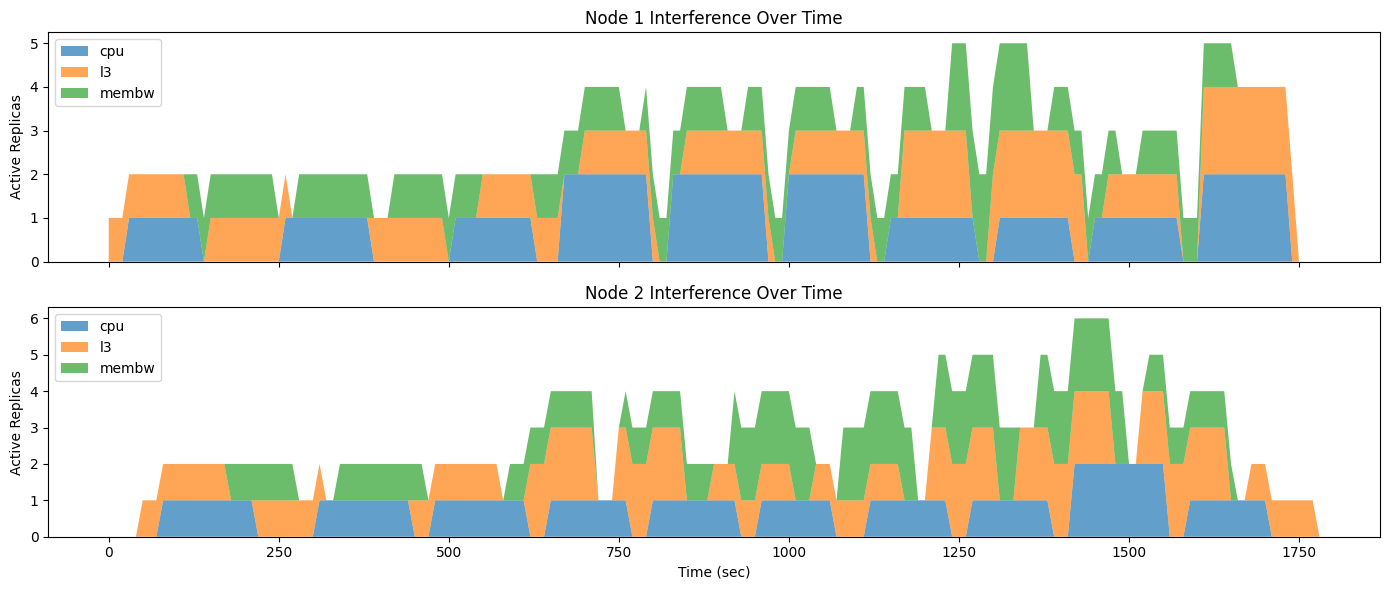

In [23]:
name = "ramp_up_schedule.csv"
generate_ramp_up_schedule(name)
plot_interference_schedule(name)

### 2. Split Flavor Schedule

In [3]:
import pandas as pd
import random

# === Configurable Parameters ===
TOTAL_DURATION = 1800  # seconds (30 minutes)
CYCLE_DURATION_RANGE = (100, 140)
REDEPLOY_WAIT = 30
SPACING_RANGE = (5, 20)
VALID_REPLICAS = [1, 2]
MAX_REPLICAS_PER_NODE = 4

DEPLOYMENTS = {
    "ibench-cpu-node1": ("node1", "cpu"),
    "ibench-cpu-node2": ("node2", "cpu"),
    "ibench-membw-node1": ("node1", "membw"),
    "ibench-membw-node2": ("node2", "membw"),
    "ibench-l3-node1": ("node1", "l3"),
    "ibench-l3-node2": ("node2", "l3")
}

def generate_flavor_split_schedule(filename, total_duration=TOTAL_DURATION):
    timeline = []
    last_deletion = {name: -REDEPLOY_WAIT for name in DEPLOYMENTS}
    current_time = 0

    # Track active replicas per node
    active_replicas = {"node1": 0, "node2": 0}
    active_cycles = []

    while current_time < total_duration:
        # Remove finished cycles and update active replicas
        active_cycles = [c for c in active_cycles if c["delete_time"] > current_time]
        active_replicas = {"node1": 0, "node2": 0}
        for c in active_cycles:
            active_replicas[c["node"]] += c["replicas"]

        # Candidate pool biased toward flavor preference
        if random.random() < 0.5:
            candidates = ["ibench-cpu-node1", "ibench-membw-node2"]
        elif random.random() < 0.85:
            candidates = ["ibench-l3-node1", "ibench-l3-node2"]
        else:
            candidates = list(DEPLOYMENTS.keys())

        # Filter based on cooldown and current load
        available = [
            dep for dep in candidates
            if current_time - last_deletion[dep] >= REDEPLOY_WAIT and
               active_replicas[DEPLOYMENTS[dep][0]] < MAX_REPLICAS_PER_NODE
        ]

        if not available:
            current_time += 5
            continue

        dep = random.choice(available)
        node, flavor = DEPLOYMENTS[dep]
        duration = random.randint(*CYCLE_DURATION_RANGE)
        if current_time + duration > total_duration:
            break

        # Ensure we don't exceed max replicas
        max_allowed = MAX_REPLICAS_PER_NODE - active_replicas[node]
        if max_allowed <= 0:
            current_time += 5
            continue
        replicas = min(random.choice(VALID_REPLICAS), max_allowed)

        type_str = f"ibench-{flavor}"

        timeline.append({
            "timestamp_sec": current_time,
            "action": "create",
            "deployment_name": dep,
            "replicas": replicas,
            "type": type_str,
            "description": f"{flavor} pod for {node} created"
        })

        delete_time = current_time + duration
        timeline.append({
            "timestamp_sec": delete_time,
            "action": "delete",
            "deployment_name": dep,
            "replicas": "",
            "type": type_str,
            "description": f"{flavor} pod for {node} deleted"
        })

        # Update tracking
        last_deletion[dep] = delete_time
        active_cycles.append({
            "deployment": dep,
            "node": node,
            "replicas": replicas,
            "delete_time": delete_time
        })

        current_time += random.randint(*SPACING_RANGE)

    # Save to file
    df = pd.DataFrame(sorted(timeline, key=lambda x: x["timestamp_sec"]))
    df.to_csv(filename, index=False)
    print(f"✅ CSV saved to: {filename}")

# Run it
#generate_flavor_split_schedule("scenario3_flavor_split.csv")


✅ CSV saved to: flavor_split_interference_schedule.csv


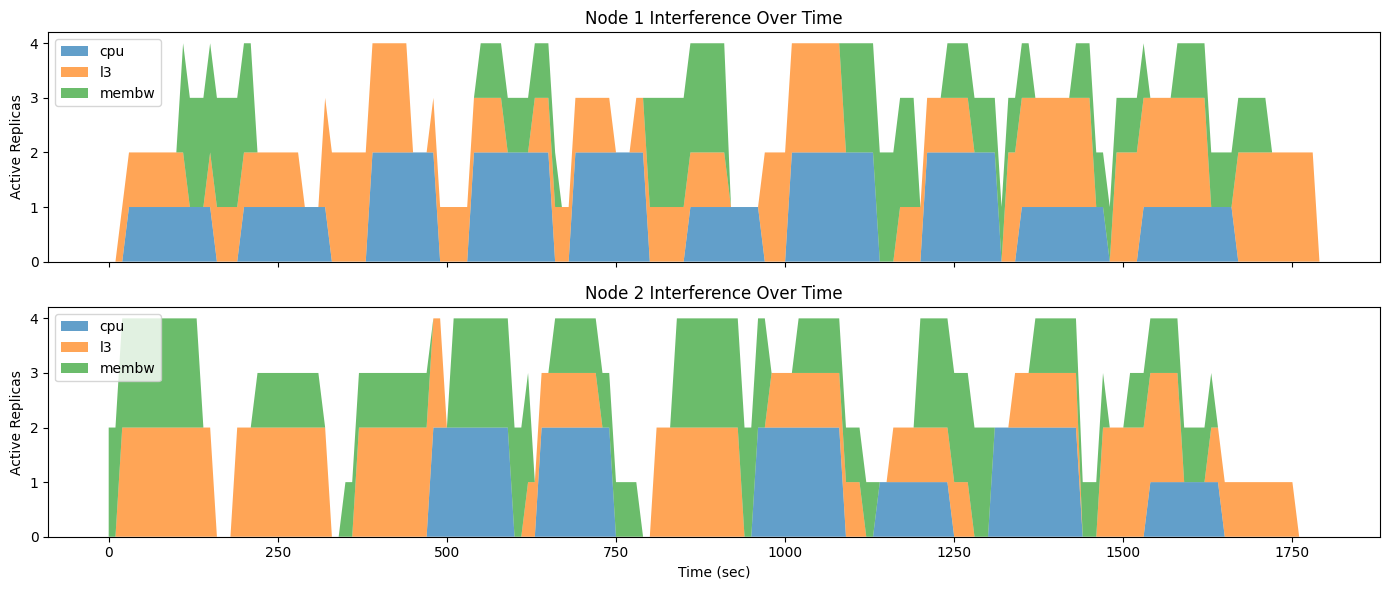

In [4]:
name = "flavor_split_interference_schedule.csv"

# Example usage (uncomment the line below to run locally):
generate_flavor_split_schedule(name)

plot_interference_schedule(name)

### 3. Light Interference Schedule

In [18]:
# === Configurable Parameters ===
TOTAL_DURATION = 1800  # seconds (30 minutes)
CYCLE_DURATION_RANGE = (100, 140)
REDEPLOY_WAIT = 30
SPACING_RANGE = (8, 25)  # a bit more spacing to keep load light
VALID_REPLICAS = [1, 2]
MAX_REPLICAS_PER_NODE = 3  # lower concurrency to reduce load

DEPLOYMENTS = {
    "ibench-cpu-node1": ("node1", "cpu"),
    "ibench-cpu-node2": ("node2", "cpu"),
    "ibench-membw-node1": ("node1", "membw"),
    "ibench-membw-node2": ("node2", "membw"),
    "ibench-l3-node1": ("node1", "l3"),
    "ibench-l3-node2": ("node2", "l3")
}

def generate_light_balanced_schedule(filename, total_duration=TOTAL_DURATION):
    timeline = []
    last_deletion = {name: -REDEPLOY_WAIT for name in DEPLOYMENTS}
    current_time = 0
    active_cycles = []

    while current_time < total_duration:
        # Remove expired deployments and recalculate replicas per node
        active_cycles = [c for c in active_cycles if c["delete_time"] > current_time]
        active_replicas = {"node1": 0, "node2": 0}
        for c in active_cycles:
            active_replicas[c["node"]] += c["replicas"]

        # Available deployments (respect cooldown + max replicas)
        available = [
            dep for dep in DEPLOYMENTS
            if current_time - last_deletion[dep] >= REDEPLOY_WAIT and
               active_replicas[DEPLOYMENTS[dep][0]] < MAX_REPLICAS_PER_NODE
        ]

        if not available:
            current_time += 5
            continue

        dep = random.choice(available)
        node, flavor = DEPLOYMENTS[dep]
        duration = random.randint(*CYCLE_DURATION_RANGE)
        if current_time + duration > total_duration:
            break

        max_allowed = MAX_REPLICAS_PER_NODE - active_replicas[node]
        if max_allowed <= 0:
            current_time += 5
            continue
        replicas = min(random.choice(VALID_REPLICAS), max_allowed)

        type_str = f"ibench-{flavor}"

        timeline.append({
            "timestamp_sec": current_time,
            "action": "create",
            "deployment_name": dep,
            "replicas": replicas,
            "type": type_str,
            "description": f"{flavor} pod for {node} created"
        })

        delete_time = current_time + duration
        timeline.append({
            "timestamp_sec": delete_time,
            "action": "delete",
            "deployment_name": dep,
            "replicas": "",
            "type": type_str,
            "description": f"{flavor} pod for {node} deleted"
        })

        last_deletion[dep] = delete_time
        active_cycles.append({
            "deployment": dep,
            "node": node,
            "replicas": replicas,
            "delete_time": delete_time
        })

        current_time += random.randint(*SPACING_RANGE)

    df = pd.DataFrame(sorted(timeline, key=lambda x: x["timestamp_sec"]))
    df.to_csv(filename, index=False)
    print(f"✅ CSV saved to: {filename}")



✅ CSV saved to: light_interference_schedule.csv


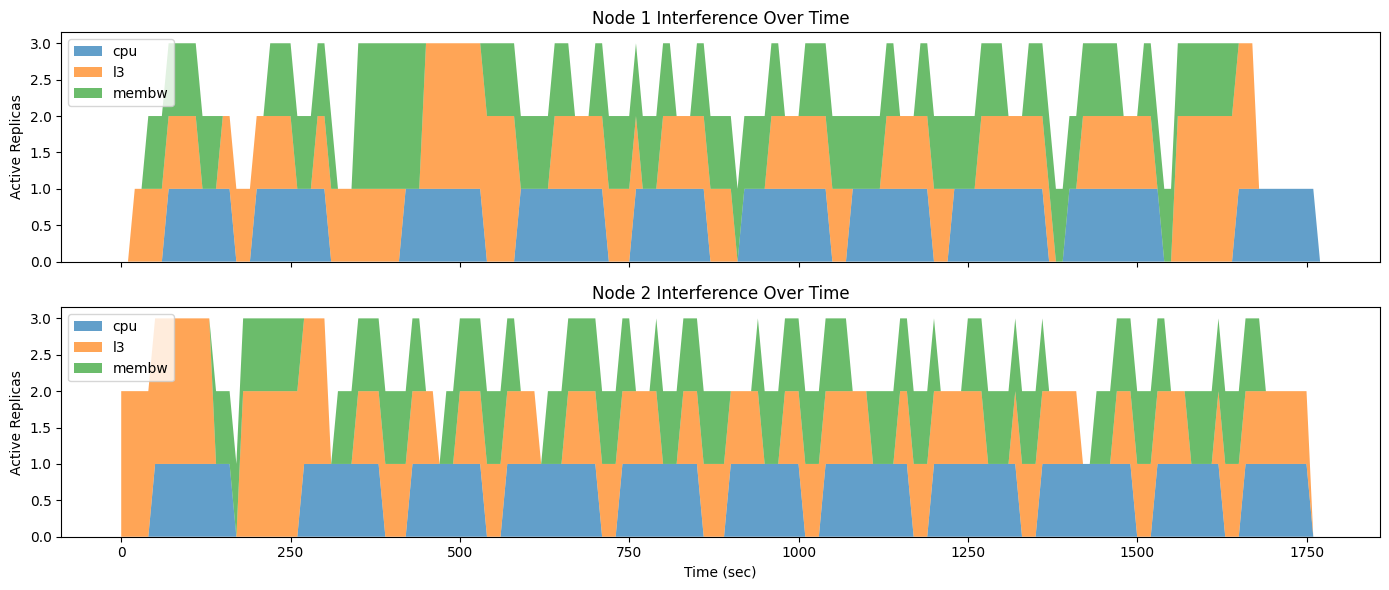

In [19]:
name = "light_interference_schedule.csv"
generate_light_balanced_schedule(name)
plot_interference_schedule(name)

In [4]:
import pandas as pd
import random

# === Updated Configurable Parameters ===
TOTAL_DURATION = 1800  # seconds (30 minutes)
CYCLE_DURATION_RANGE = (160, 200)
REDEPLOY_WAIT = 60
SPACING_RANGE = (8, 25)
VALID_REPLICAS = [1, 2]
MAX_REPLICAS_PER_NODE = 3
MAX_TOTAL_REPLICAS = 5

DEPLOYMENTS = {
    "ibench-cpu-node1": ("node1", "cpu"),
    "ibench-cpu-node2": ("node2", "cpu"),
    "ibench-membw-node1": ("node1", "membw"),
    "ibench-membw-node2": ("node2", "membw"),
    "ibench-l3-node1": ("node1", "l3"),
    "ibench-l3-node2": ("node2", "l3")
}

def generate_light_balanced_schedule(filename, total_duration=TOTAL_DURATION):
    timeline = []
    last_deletion = {name: -REDEPLOY_WAIT for name in DEPLOYMENTS}
    current_time = 0
    active_cycles = []

    while current_time < total_duration:
        # Remove expired deployments and update active replica counters
        active_cycles = [c for c in active_cycles if c["delete_time"] > current_time]
        active_replicas = {"node1": 0, "node2": 0}
        total_active_replicas = 0

        for c in active_cycles:
            active_replicas[c["node"]] += c["replicas"]
            total_active_replicas += c["replicas"]

        # Find eligible deployments based on cooldown and per-node replica limits
        available = [
            dep for dep in DEPLOYMENTS
            if current_time - last_deletion[dep] >= REDEPLOY_WAIT and
               active_replicas[DEPLOYMENTS[dep][0]] < MAX_REPLICAS_PER_NODE
        ]

        if not available:
            current_time += 5
            continue

        dep = random.choice(available)
        node, flavor = DEPLOYMENTS[dep]
        duration = random.randint(*CYCLE_DURATION_RANGE)
        if current_time + duration > total_duration:
            break

        # Determine how many replicas we can add without breaking limits
        max_node = MAX_REPLICAS_PER_NODE - active_replicas[node]
        max_total = MAX_TOTAL_REPLICAS - total_active_replicas
        max_allowed = min(max_node, max_total)

        if max_allowed <= 0:
            current_time += 5
            continue

        replicas = min(random.choice(VALID_REPLICAS), max_allowed)
        type_str = f"ibench-{flavor}"

        # Create pod
        timeline.append({
            "timestamp_sec": current_time,
            "action": "create",
            "deployment_name": dep,
            "replicas": replicas,
            "type": type_str,
            "description": f"{flavor} pod for {node} created"
        })

        delete_time = current_time + duration
        timeline.append({
            "timestamp_sec": delete_time,
            "action": "delete",
            "deployment_name": dep,
            "replicas": "",
            "type": type_str,
            "description": f"{flavor} pod for {node} deleted"
        })

        last_deletion[dep] = delete_time
        active_cycles.append({
            "deployment": dep,
            "node": node,
            "replicas": replicas,
            "delete_time": delete_time
        })

        current_time += random.randint(*SPACING_RANGE)

    df = pd.DataFrame(sorted(timeline, key=lambda x: x["timestamp_sec"]))
    df.to_csv(filename, index=False)
    print(f"✅ CSV saved to: {filename}")


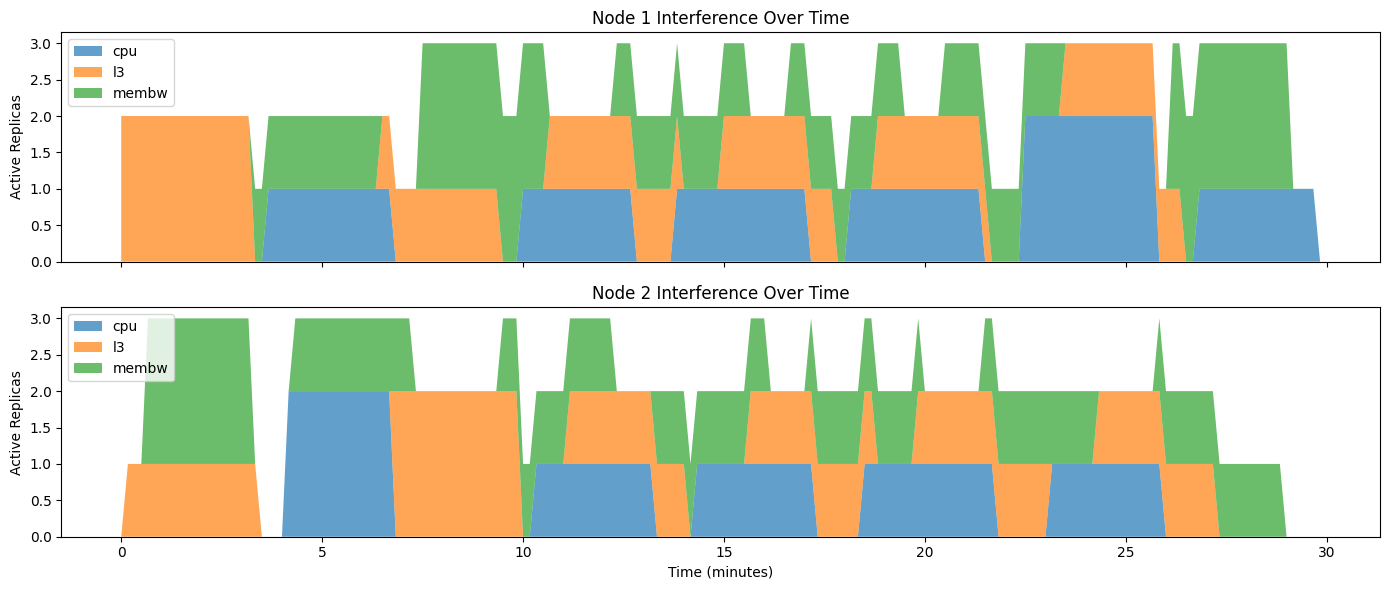

In [8]:
name = "lightLong_interference_schedule.csv"
# Example usage (uncomment the line below to run locally):
#generate_light_balanced_schedule(name)
plot_interference_schedule(name)